# Granger Causality Test

The approach and the dataset are based on: https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

### Ipo Dam Dataset

We will use the Ipo dataset in this example. It contains daily measurements of the following variables: rainfall (in millimeters) dam water level (in meters), beside Oceanic Niño Index (ONI), NIA release flow (in cubic meters per second), which we will drop for now. 

In [3]:
ipo_df = pd.read_csv('Ipo_dataset.csv', index_col='Time');
ipo_df = ipo_df.dropna()
data_df = ipo_df.drop(['ONI', 'NIA'], axis=1)
ipo_df.head()

,Rain,ONI,NIA,Dam
Time,,,,
0,0.0,-0.7,38.225693,100.70
1,0.0,-0.7,57.996530,100.63
2,0.0,-0.7,49.119213,100.56
3,0.0,-0.7,47.034720,100.55
4,0.0,-0.7,42.223380,100.48


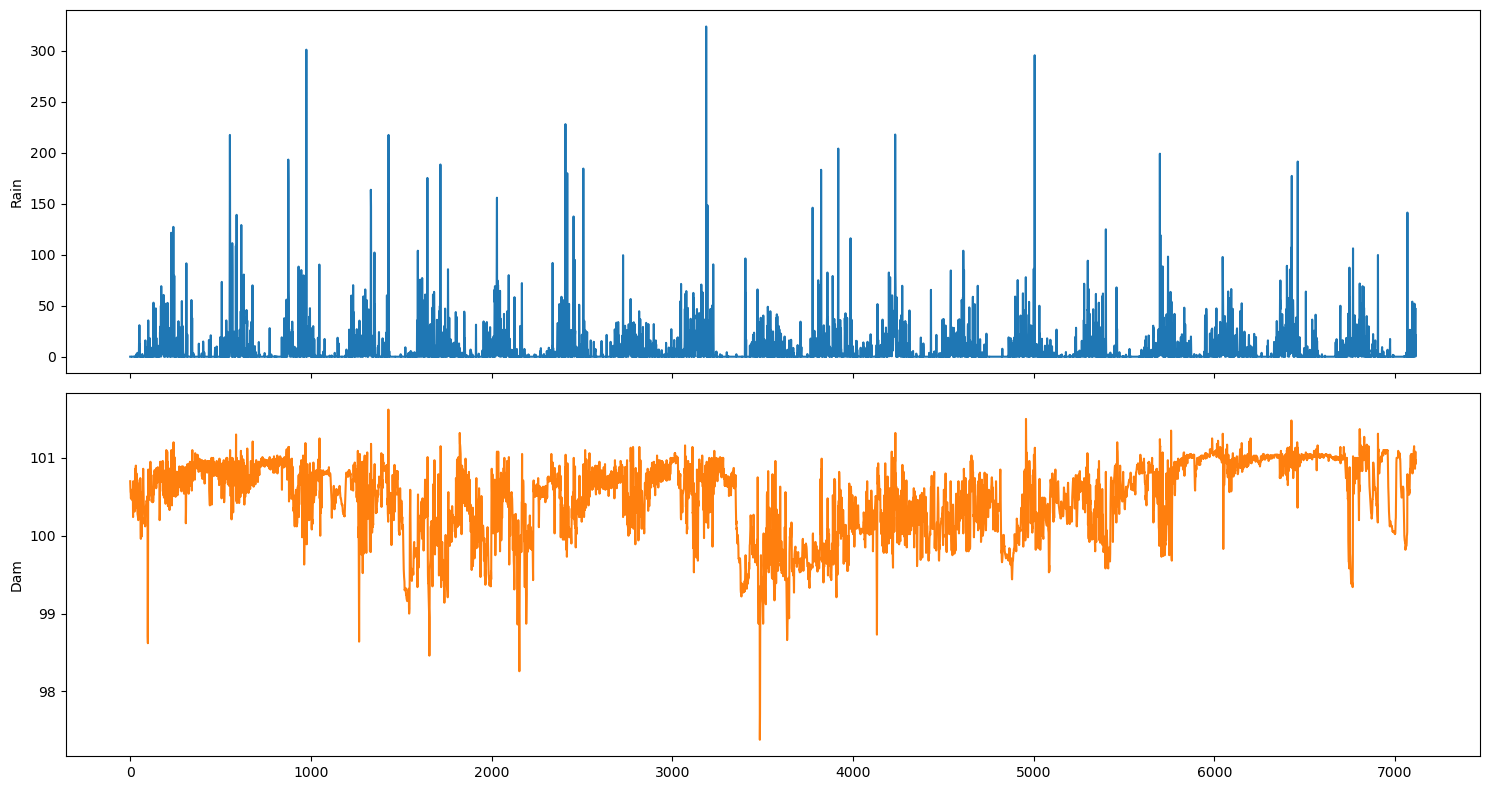

In [4]:
fig,ax = plt.subplots(2, figsize=(15,8), sharex=True)
plot_cols = ['Rain', 'Dam']
data_df[plot_cols].plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(plot_cols[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

We look at the lag plots to quickly check for stationarity.

In [7]:
def lag_plots(data_df):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    lag_plot(data_df[data_df.columns[0]], lag=1, ax=ax1)
    ax1.set_title(data_df.columns[0]);

    lag_plot(data_df[data_df.columns[1]], lag=1, ax=ax2)
    ax2.set_title(data_df.columns[1]);

    ax1.set_ylabel('$x_{t+1}$');
    ax1.set_xlabel('$x_t$');
    ax2.set_ylabel('$x_{t+1}$');
    ax2.set_xlabel('$x_t$');

    plt.tight_layout()

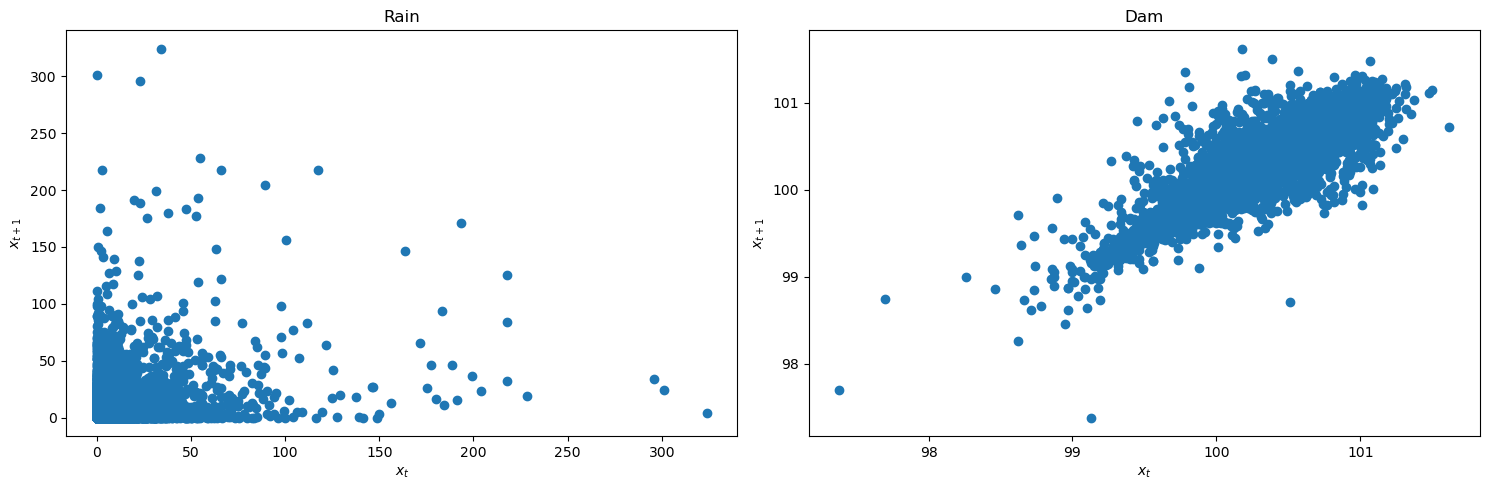

In [8]:
lag_plots(data_df)

**Result:** Dam does not look stationary. Rainfall lag plot is inconclusive.

### Check stationarity

To check for stationarity, we use the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test. For the data to be suitable for VAR modelling, we need each of the variables in the multivariate time series to be stationary. In both tests, we need the test statistic to be less than the critical values to say that a time series (a variable) to be stationary. 

### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test ###
- **Null hypothesis** ($H_0$): The time series is stationary (stationary around a mean or a deterministic trend).
- **Alternative Hypothesis** ($H_1$): The time series is not stationary.

The KPSS test involves estimating the following model:
$$X_t = \mu + \delta t + \epsilon_t $$

Where:
    $X_t$: Observed time series.
    $\mu$ : Constant (mean).
    $\delta t$: Deterministic trend component.
    $\epsilon_t$: Stationary error process (white noise).

KPSS Test Statistic:
- Measures the variance of the random walk (if present).
- **A large test statistic suggests non-stationarity** (above critical value, with small p-value (p < 0.05)).

In [9]:
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [10]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0171,1.3155
p-value,0.1000,0.0100
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


**Result:** Rain is stationary, while Dam is not.

Since the lag plot and KPSS test indicate that Dam is not stationary, we apply differencing first before building our VAR model.

In [11]:
data_df['Dam'] = data_df['Dam'] - data_df['Dam'].shift(1)
data_df = data_df.dropna()

We again look at the lag plots and apply the KPSS tests.

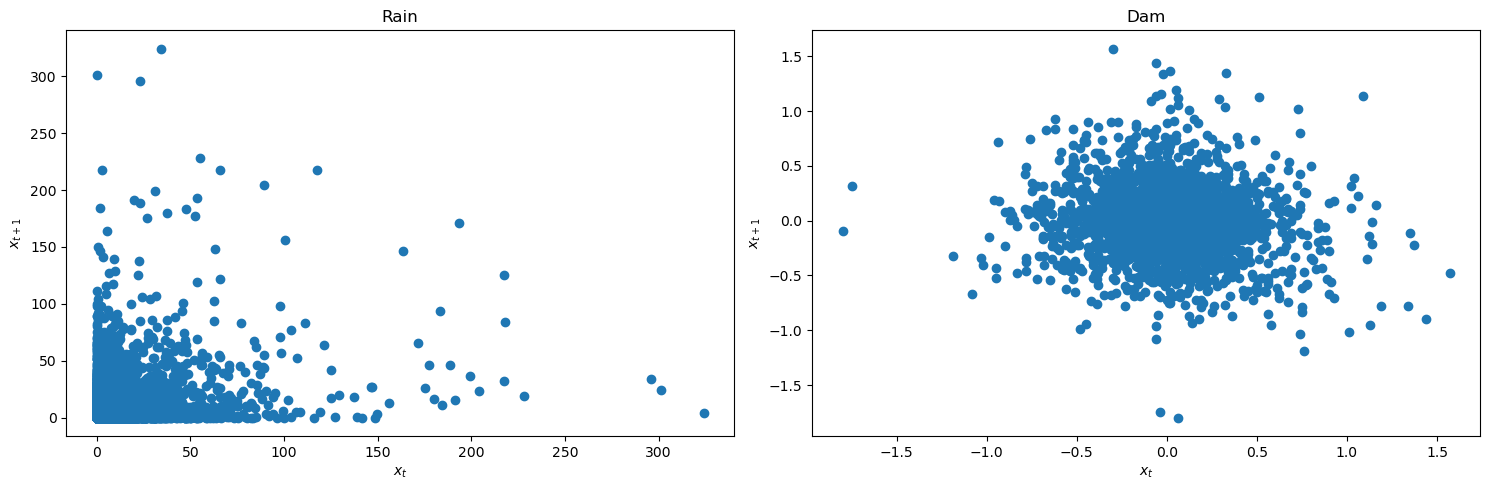

In [12]:
lag_plots(data_df)

In [13]:
kpss_test(data_df)

,Rain,Dam
Test statistic,0.0171,0.0128
p-value,0.1000,0.1000
Critical value - 1%,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760
Critical value - 5%,0.1460,0.1460
Critical value - 10%,0.1190,0.1190


# Select best lag for VAR model

We next split the data into train and test sets for the VAR model.

In [16]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [17]:
train_df, test_df = splitter(data_df)

We then select the VAR order $p$ by computing the different multivariate information criteria BIC.

In [18]:
def select_p(train_df):
    bic = []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        bic.append(result.bic)
    lags_metrics_df = pd.DataFrame({'BIC': bic}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 1, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

BIC    8
dtype: int64


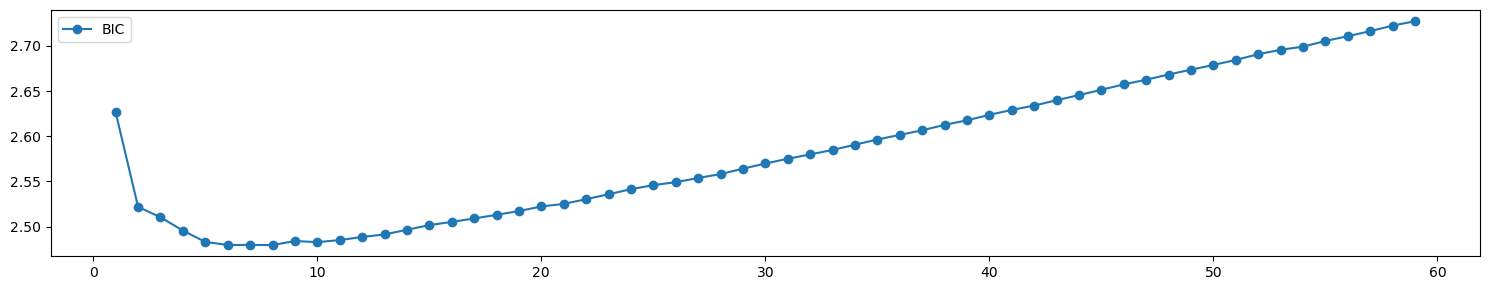

In [19]:
select_p(train_df)

**Result:** We see that BIC has the lowest value at $p=8$. 

We now fit the VAR model with the chosen order.

In [35]:
p = 8
model = VAR(train_df)
var_model = model.fit(p)

In [36]:
#df = pd.DataFrame(np.zeros((len(train_df.columns), len(train_df.columns))), columns=train_df.columns, index=train_df.columns)
#for c in df.columns:
#    for r in df.index:
#        print(train_df[[r, c]])

We can finally test the variables for Granger Causality

In [42]:
def granger_causation_matrix(data, variables, p, test = 'params_ftest', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [43]:
granger_causation_matrix(train_df, train_df.columns, p)  

,Rain_x,Dam_x
Rain_y,0.0,0.2188
Dam_y,0.0,0.0000


**Recall:** If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

**Results:** For this particular example, we can say that rainfall Granger causes changes in the dam water level. This means that rainfall data improves changes in dam water level prediction performance.

On the other hand, changes in dam water level does not Granger cause rainfall. This means that changes in dam water level data does not improve rainfall prediction performance.